### Mount gdrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
root = '/content/drive/My Drive/CS489 Team 3 Project/Irfan\'s code'

### Import Libraries

In [3]:
import os

# Regular modules for data science and visualization:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Keras (2.2.4) and tensorflow (1.13).
import tensorflow as tf
import tensorflow_hub as hub

from keras.regularizers import l1, l2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import backend
from tensorflow.keras import optimizers

#sklearn and imblearn modules:
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix

In [4]:
csv = [root + '/articles1.csv', root + '/articles2.csv', root + '/articles3.csv']
df = pd.concat(map(pd.read_csv, csv), ignore_index=True)
df = df[df.index % 3 == 0]
df

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
6,6,17289,Taiwan’s President Accuses China of Renewed In...,New York Times,Javier C. Hernández,2017-01-02,2017.0,1.0,NaN,BEIJING — President Tsai of Taiwan sharpl...
9,9,17292,Calling on Angels While Enduring the Trials of...,New York Times,Andy Newman,2016-12-31,2016.0,12.0,NaN,Angels are everywhere in the Muñiz family’s ap...
12,12,17295,"Mar-a-Lago, the Future Winter White House and ...",New York Times,Maggie Haberman,2017-01-02,2017.0,1.0,NaN,"WEST PALM BEACH, Fla. — When Donald J. Tr..."
...,...,...,...,...,...,...,...,...,...,...
142557,146020,218070,Kerry manages to alienate our closest friends ...,Washington Post,Jennifer Rubin,2016-12-30,2016.0,12.0,https://web.archive.org/web/20161231004909/htt...,President Obama’s decision to abstain at ...
142560,146023,218073,What U.S. Muslims fear from Trump,Washington Post,Naureen Shah,2016-12-30,2016.0,12.0,https://web.archive.org/web/20161231004909/htt...,Naureen Shah is director of security and hu...
142563,146026,218076,China’s vow to shut down its ivory trade by th...,Washington Post,Simon Denyer,2016-12-30,2016.0,12.0,https://web.archive.org/web/20161231004909/htt...,BEIJING — China promised Friday to halt ...
142566,146029,218079,Plane carrying six people returning from a Cav...,Washington Post,Sarah Larimer,2016-12-30,2016.0,12.0,https://web.archive.org/web/20161231004909/htt...,Crews on Friday continued to search L...


###**Manually labelled according to https://mediabiasfactcheck.com/**

*   **New York Times**: Left-center<br>
*   **Breitbart**: Extreme right <br>
*   **CNN**: Left<br>
*   **Business Insider**: Left-center <br>
*   **Atlantic**: Left-center <br>
*   **Fox News**: Right<br>
*   **Talking Points Memo**: Left <br>
*   **Buzzfeed News**: Left-center <br>
*   **National Review**: Right <br>
*   **New York Post**: Right-center <br>
*   **Guardian**: Left-center<br>
*   **NPR**: Left-center<br>
*   **Reuters**: Right<br>
*   **Vox**: Left<br>
*   **Washington Post**: Left-center


###**The label is as follows:**
*   Left: 1
*   Left-center: 2
*   Right-center: 3
*   Right: 4





### make the list of content from the dataframe

In [5]:
pub_list = ['New York Times', 'Breitbart', 'CNN', 'Business Insider', 'Atlantic', 'Fox News',
            'Talking Points Memo', 'Buzzfeed News', 'National Review', 'New York Post',
            'Guardian', 'NPR', 'Reuters', 'Vox', 'Washington Post']

pub_dict = {}

for pub in pub_list:
  pub_dict[pub] = df[df['publication'] == pub]

n_s = []

for pub in pub_dict:
  n_s += list(pub_dict[pub].iloc[:,9].values)

print(len(n_s))

47524


###remove the publication word from the sentence

In [6]:
for word in n_s:
  for pub in pub_dict:
    word.replace(pub,'')

In [7]:
#Bias classifier:
#    Left: 1
#    Left-center: 2
#    Right-center: 3
#    Right: 4

classes_Bias = np.asarray([2 for i in range(len(pub_dict['New York Times']))] + 
                          [4 for i in range(len(pub_dict['Breitbart']))] + 
                          [1 for i in range(len(pub_dict['CNN']))] + 
                          [2 for i in range(len(pub_dict['Business Insider']))] +
                          [2 for i in range(len(pub_dict['Atlantic']))] + 
                          [4 for i in range(len(pub_dict['Fox News']))] + 
                          [1 for i in range(len(pub_dict['Talking Points Memo']))] + 
                          [2 for i in range(len(pub_dict['Buzzfeed News']))] + 
                          [4 for i in range(len(pub_dict['National Review']))] + 
                          [3 for i in range(len(pub_dict['New York Post']))] + 
                          [2 for i in range(len(pub_dict['Guardian']))] + 
                          [2 for i in range(len(pub_dict['NPR']))] + 
                          [4 for i in range(len(pub_dict['Reuters']))] + 
                          [1 for i in range(len(pub_dict['Vox']))] + 
                          [2 for i in range(len(pub_dict['Washington Post']))])


In [8]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [9]:
# Load the encoder:
g = tf.Graph()
with g.as_default():
  text_input = tf.placeholder(dtype=tf.string, shape=[None])
  embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-large/3")
  embedded_text = embed(text_input)
  init_op = tf.group([tf.global_variables_initializer(), tf.tables_initializer()])
g.finalize()

# Initialize session:
session = tf.Session(graph=g)
session.run(init_op)

#Function to compute all embeddings for each sentence:
#Be patient, takes a little while:
def similarity_matrix(merge_list):
    #initialize distance array:
    #initialize embeddings array:
    emb_all = np.zeros([len(merge_list),512])
    #Outer for loop:
    for i in range(0,len(merge_list)):
        #Here is where we run the previously started session, so it is important to run previous step succesfully:
        i_emb = session.run(embedded_text, feed_dict={text_input: [merge_list[i]]})
        emb_all[i,:] = i_emb
    return emb_all

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [10]:
e_All_four = similarity_matrix(n_s)

In [11]:
#save the array for later usage
np.save(root + '/e_All_four.npy', e_All_four)

In [12]:
#Choose optimizer:
optim = optimizers.Adam(learning_rate=0.00015) 

# create NN for news clissification:
news_LSTM = Sequential()
news_LSTM.add(LSTM(40, input_dim=512, activation = 'relu',kernel_regularizer=l2(0.1), return_sequences=True))
news_LSTM.add(Dropout(0.25))
news_LSTM.add(LSTM(40, activation = 'relu',kernel_regularizer=l2(0.1)))
news_LSTM.add(Dropout(0.25))


# Output layer with multiclass activation function:
news_LSTM.add(Dense(4,activation='softmax'))

# Compile model:
news_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['acc'])

In [13]:
news_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 40)          88480     
                                                                 
 dropout (Dropout)           (None, None, 40)          0         
                                                                 
 lstm_1 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense (Dense)               (None, 4)                 164       
                                                                 
Total params: 101,604
Trainable params: 101,604
Non-trainable params: 0
_________________________________________________________________


In [22]:
# split into shuffled folds:
#Note that you should edit the class array accordingly: Bias (classes_Bias) or Outlet (classes_All)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33) # chose one split to make analysis faster. change it if required
scaler = StandardScaler()
for t, te in sss.split(e_All_four, classes_Bias):
  # Scale the data with StandardScaler before splitting:
    X_train, X_test = scaler.fit_transform(e_All_four)[t], scaler.fit_transform(e_All_four)[te]

    y_train, y_test = classes_Bias[t]-1,classes_Bias[te]-1

print(X_train.shape)

(31841, 512)


In [23]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [24]:
#fit the network. You can change parameters to see how this affects your training.
m_h = news_LSTM.fit(X_train, y_train, epochs=400, validation_data=(X_test, y_test), batch_size=32, verbose=1)

Train on 31841 samples, validate on 15683 samples
Epoch 1/400
31808/31841 [============================>.] - ETA: 0s - loss: 8.1877 - acc: 0.4043

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


31841/31841 [==============================] - 5s 169us/sample - loss: 8.1809 - acc: 0.4043 - val_loss: 1.6525 - val_acc: 0.4095
Epoch 2/400
31841/31841 [==============================] - 5s 152us/sample - loss: 1.3634 - acc: 0.4095 - val_loss: 1.2772 - val_acc: 0.4095
Epoch 3/400
31841/31841 [==============================] - 5s 151us/sample - loss: 1.2752 - acc: 0.4095 - val_loss: 1.2734 - val_acc: 0.4095
Epoch 4/400
31841/31841 [==============================] - 5s 152us/sample - loss: 1.2743 - acc: 0.4095 - val_loss: 1.2733 - val_acc: 0.4095
Epoch 5/400
31841/31841 [==============================] - 5s 152us/sample - loss: 1.2743 - acc: 0.4095 - val_loss: 1.2733 - val_acc: 0.4095
Epoch 6/400
31841/31841 [==============================] - 5s 151us/sample - loss: 1.2743 - acc: 0.4095 - val_loss: 1.2733 - val_acc: 0.4095
Epoch 7/400
31841/31841 [==============================] - 5s 151us/sample - loss: 1.2742 - acc: 0.4095 - val_loss: 1.2733 - val_acc: 0.4095
Epoch 8/400
31841/31841 [

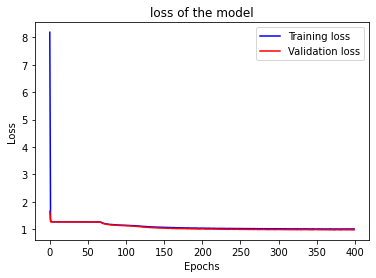

In [25]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(m_h, "loss of the model")

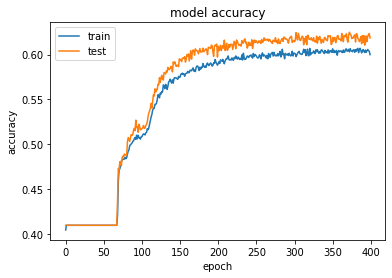

In [26]:
def visualize_acc(history):
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

visualize_acc(m_h)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


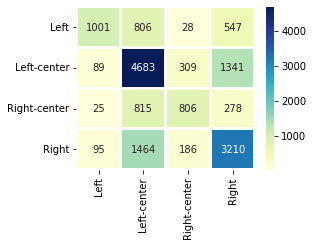

In [27]:
# Plot confusion matrix:
y_pred = news_LSTM.predict(X_test)
classes_y= np.argmax(y_pred,axis=1)


plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test,classes_y),annot=True,linewidths=2, cmap="YlGnBu",fmt="g", xticklabels=['Left','Left-center', 'Right-center', 'Right'], yticklabels=['Left','Left-center', 'Right-center', 'Right']) # Or change labels to ['outlet1','outlet2','outlet3','outlet4'] for outlet classifier
plt.autoscale()
plt.savefig('confusion_matrix_outlet_bias_bal.png',format='PNG',bbox_inches = "tight") # edit file title here

In [29]:
pred = news_LSTM.predict(X_test)
classes_y= np.argmax(pred,axis=1)
print(classes_y)
print(X_test.shape)
print(X_test[0].shape)

[3 1 1 ... 1 2 0]
(15683, 1, 512)
(1, 512)


In [37]:
def make_pred(news_text):
  sim_matrix = session.run(embedded_text, feed_dict={text_input: [news_text]})
  combine = np.vstack([e_All_four, sim_matrix])
  sca = scaler.fit_transform(combine)[-1]
  sca = np.array([sca])
  sca = sca.reshape(sca.shape[0], 1, sca.shape[1])
  pred = news_LSTM.predict(sca)
  classes_y= np.argmax(pred,axis=1)

  if classes_y[0] == 0:
    return 'Left'
  elif  classes_y[0] == 1:
    return 'Left-center'
  elif  classes_y[0] == 2:
    return 'right-center'
  else:
    return 'right'

In [38]:
text = 'Former Vice President Joe Biden (D) defeated Trump in the 2020 presidential election on November 3, 2020. Biden received 306 electoral votes, while Trump received 232. Trump won the 2016 presidential election against Hillary Clinton (D), receiving 304 electoral votes. Key policy initiatives during Trump\'s first term included the United States withdrawing from the Iran nuclear deal, the passage of the Tax Cuts and Jobs Act of 2017 and First Step Act in 2018, reducing the size of the ISIS caliphate, and establishing the Space Force as an independent military branch.[1][2] Trump made more than 200 federal judicial appointments, including three U.S. Supreme Court justices. During his presidency, Trump issued nine vetoes. To read more about these vetoes, click here. On December 18, 2019, Trump became the third president in U.S. history to be impeached by the U.S. House.[3] The U.S. Senate acquitted Trump on both charges of abuse of power and obstruction of Congress on February 5, 2020.[4] Trump was impeached a second time on January 13, 2021, for incitement of insurrection. The Senate acquitted Trump on February 13, 2021.'

make_pred(text)

'Left-center'

In [ ]:
news_LSTM.save(root + '/news_LSTM_four')